In [1]:
import numpy as np
import scipy.integrate as integrate
import pandas as pd
import QuantLib as ql
from scipy import optimize
from financepy.models.black import *
from financepy.utils.global_types import *
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [2]:
def carr_madan_integrand(cf, logk, u, alpha):
    top = cf(complex(u, -(alpha+1.0))) * np.exp(complex(0.0, -u*logk))
    bottom = complex(alpha*alpha + alpha - u*u, (2.0*alpha + 1.0)*u)
    result = top/bottom
    return result.real 

def blackImpliedVol(forward, K, T, DF, price):    
    min_ivol, max_ivol = 0.001, 1.0
    f = lambda ivol: Black(ivol).value(forward, K, T, DF, OptionTypes.EUROPEAN_CALL) - price    
    return optimize.bisect(f, min_ivol, max_ivol) 

### Heston

In [3]:
# characteristic function of heston model. The notation follows The Little Heston Trap 2005.
# dF_t/F_t = sqrt(v_t)dW_t
# dv_t = kappa*(nu-v_t) dt + lambda * sqrt(v_t)dZ_t
# E[dWdZ] = rho dt
def heston_cf(forward, vol_0, kappa, nu, lam, rho, t, u):
    # pre computed values
    rliu_m_k = complex(-kappa, rho * lam * u)
    d = np.sqrt( rliu_m_k * rliu_m_k + complex(lam*lam*u*u, lam*lam*u) )
    k_m_rliu_m_d = complex(kappa, -rho * lam * u) - d
    g2 = complex(kappa-d, -rho*lam*u) / complex(kappa+d, -rho*lam*u)
    emdt = np.exp(-d*t)
    one_m_g2 = 1.0 - g2 * emdt
    one_m_emdt = 1.0 - emdt
    v0v0ll = vol_0*vol_0/(lam*lam)
    temp1 = np.exp(complex(0.0, u * np.log(forward)))
    temp2 = k_m_rliu_m_d*t - 2.0 * np.log (one_m_g2/(1.0-g2))
    temp2 = np.exp( temp2 * nu*kappa/(lam*lam) )
    temp3 = np.exp( v0v0ll * k_m_rliu_m_d * (1.0 - emdt) / one_m_g2 )
    result = temp1 * temp2 * temp3
    return result

#vol_0,    # the volatility at time 0, NOT variance
#kappa,    # mean reversion rate
#nu,       # mean reversion level
#lam,      # vol of variance
#rho,      # correlation 
def carr_madan_heston_call_option(forward, vol_0, kappa, nu, lam , rho, t, k, r, alpha = 1.5):
    cf = lambda u: heston_cf(forward, vol_0, kappa, nu, lam, rho, t, u)
    integrand = lambda u: carr_madan_integrand(cf, np.log(k), u, alpha)
    result, error = integrate.quad(integrand, 0.0, np.inf)
    return np.exp(-r*t) * np.exp(-alpha*np.log(k)) / np.pi * result

### Merton's jump diffusion

In [4]:
def MDJ_cf(forward, vol, a, b, lam, t, u):
    lnf_factor = complex(0, u*np.log(forward))
    jump_compensation = lam*(np.exp(a+b*b/2)-1)    
    drift_and_diffusion_term = complex(-0.5*u*u*vol*vol, u*(-0.5*vol*vol - jump_compensation))
    jump_term = lam*(np.exp(complex(-0.5*b*b*u*u, u*a)) - 1)        
    return np.exp(lnf_factor + (drift_and_diffusion_term + jump_term)*t )
    
def carr_madan_MJD_call_option(forward, vol, a, b, lam, t, k, r, alpha=1.5):    
    cf = lambda u: MDJ_cf(forward, vol, a, b, lam, t, u)
    integrand = lambda u: carr_madan_integrand(cf, np.log(k), u, alpha)

    # lower limit is 0.0, upper limit is infinity
    result, error = integrate.quad(integrand, 0.0, np.inf)
    return np.exp(-r*t) * np.exp(-alpha*np.log(k)) / np.pi * result

### Calibration Routine

In [5]:
#input: 
#   vol = params[0]
#   a = params[1]
#   b = params[2]
#   lam = params[3]  
#output: list of residuals
def MJD_obj_func(forward, Ks, T, r, df_mkt, params):     
    residuals = []                               
    mdl_prices = [carr_madan_MJD_call_option(forward, params[0], params[1], params[2], params[3], T, K, r) for K in Ks]      
    mkt_prices = list(df_mkt['Heston price'])
    res = [(mdl/mkt-1.0)**2 for mdl, mkt in zip(mdl_prices, mkt_prices)]  
    residuals.extend(res)     
        
    return residuals

def unpack_MJD_calib_params(MJD_calib_res):
    vol = MJD_calib_res.x[0]; a = MJD_calib_res.x[1]; b = MJD_calib_res.x[2]; lam = MJD_calib_res.x[3]
    return vol, a, b, lam

### Generate market price using Heston model

In [6]:
S0 = 100
T = 1                  # maturity
r = 0.05              # risk free rate
q = 0.03                  # dividend yield
DF = np.exp(-r*T)
DivF = np.exp(-q*T)
forward = S0 * DivF / DF 

var_0 = 0.0989   # variance at time 0
vol_0 = np.sqrt(var_0)
kappa = 0.7331            # mean reversion rate
lam = 0.70                # vol of variance
nu = 0.3407               # mean reversion level
rho = -0.2949            # correlation 

Ks = np.linspace(70, 130, 7)
df_mkt = pd.DataFrame()
df_mkt['Strike'] = Ks
heston_prices = [carr_madan_heston_call_option(forward, vol_0, kappa, nu, lam , rho, T, K, r) for K in Ks]
df_mkt['Heston price'] = np.array(heston_prices)

heston_ivols = [blackImpliedVol(forward, K, T, DF, call_value) for call_value, K in zip(heston_prices, Ks)]    

df_mkt['Heston ivol'] = np.array(heston_ivols)

<Axes: xlabel='Strike'>

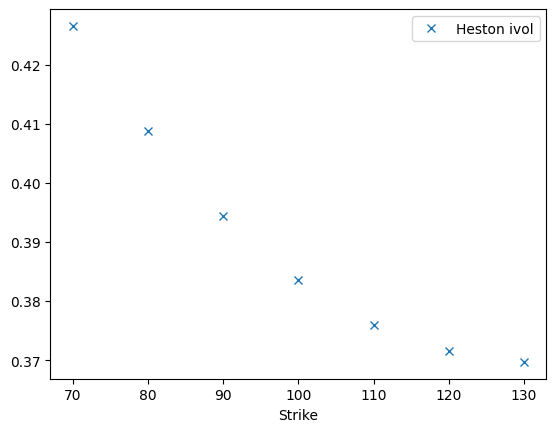

In [7]:
df_mkt.plot(x='Strike', y='Heston ivol', style='x')

### Calibrate MJD model to the market price

In [8]:
#initial values  
#init_param_MJD = np.array([vol, a, b, lam])
init_param_MJD = np.array([0.236, -0.153, 0.322, 0.973])

obj_function = lambda p: MJD_obj_func(forward, Ks, T, r, df_mkt, p)
MJD_param = optimize.least_squares(obj_function, init_param_MJD, method='lm', xtol=1E-8 )
print(MJD_param.x)

[ 0.2369185  -0.15390669  0.32246502  0.97330624]


### Check calibration accuracy

In [9]:
mjd_prices = [carr_madan_MJD_call_option(forward, \
                                         MJD_param.x[0], \
                                         MJD_param.x[1], \
                                         MJD_param.x[2], \
                                         MJD_param.x[3], T, K, r) for K in Ks]  

df_mkt['MJD price'] = np.array(mjd_prices)
mjd_ivols = [blackImpliedVol(forward, K, T, DF, call_value) for call_value, K in zip(mjd_prices, Ks)]  
df_mkt['MJD ivol'] = np.array(mjd_ivols)
           
df_mkt['diff ivol'] = df_mkt['Heston ivol'] - df_mkt['MJD ivol']

### Heston vs MJD which both matches at T=1

In [10]:
df_mkt

,Strike,Heston price,Heston ivol,MJD price,MJD ivol,diff ivol
0,70.0,33.962811,0.426616,33.959477,0.426459,0.000157
1,80.0,26.855224,0.408783,26.858224,0.408890,-0.000107
2,90.0,20.699066,0.394404,20.698973,0.394402,0.000003
3,100.0,15.591156,0.383501,15.589661,0.383462,0.000040
4,110.0,11.538755,0.375989,11.538874,0.375993,-0.000003
5,120.0,8.452795,0.371560,8.453508,0.371579,-0.000019
6,130.0,6.175944,0.369701,6.175553,0.369689,0.000011


### Check with other maturity ivol

Text(0, 0.5, 'Implied Volatility')

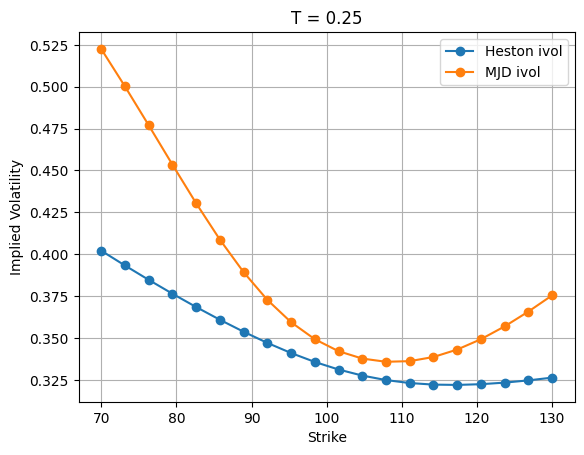

In [11]:
KKs = np.linspace(70, 130, 20)
df_other_T = pd.DataFrame()
df_other_T['Strike'] = KKs
T = 0.25
DF2 = np.exp(-r*T)
DivF2 = np.exp(-q*T)
forward2 = S0 * DivF2 / DF2 

heston_prices = [carr_madan_heston_call_option(forward2, vol_0, kappa, nu, lam , rho, T, K, r) for K in KKs]
heston_ivols = [blackImpliedVol(forward2, K, T, DF2, call_value) for call_value, K in zip(heston_prices, KKs)] 

df_other_T['Heston price'] = np.array(heston_prices)
df_other_T['Heston ivol'] = np.array(heston_ivols)

mjd_prices = [carr_madan_MJD_call_option(forward2, MJD_param.x[0], MJD_param.x[1], MJD_param.x[2], MJD_param.x[3], \
                                         T, K, r) for K in KKs] 
mjd_ivols = [blackImpliedVol(forward2, K, T, DF2, call_value) for call_value, K in zip(mjd_prices, KKs)]  

df_other_T['MJD price'] = np.array(mjd_prices)
df_other_T['MJD ivol'] = np.array(mjd_ivols)

ax = df_other_T.plot(x='Strike', y=['Heston ivol', 'MJD ivol'], grid=True, style='-o')
plt.title('T = ' + str(T))
ax.set_xlabel('Strike')
ax.set_ylabel('Implied Volatility')
#plt.savefig("L8_Heston_vs_MJD_025.png")